In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
import gc
import math

In [2]:
data_frame = pd.read_pickle("../data/interim/train_data.pkl")

In [3]:
data_frame.primary_use.unique().size

16

In [4]:
data_frame.site_id.unique().size

16

In [5]:
data_frame.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0


In [6]:
timestamp = data_frame['timestamp']
#data_frame.drop("timestamp")
timestamp_seconds_of_day = (timestamp.dt.hour * 60 + timestamp.dt.minute) * 60 + timestamp.dt.second
data_frame["time_sin"] = np.sin(2 * np.pi * timestamp_seconds_of_day / 86400)
data_frame["time_cos"] = np.cos(2 * np.pi * timestamp_seconds_of_day / 86400)
data_frame["dayofweek_sin"] = np.sin(2 * np.pi * timestamp.dt.dayofweek / 7)
data_frame["dayofweek_cos"] = np.cos(2 * np.pi * timestamp.dt.dayofweek / 7)
data_frame["dayofyear_sin"] = np.sin(2 * np.pi * timestamp.dt.dayofyear / 366)
data_frame["dayofyear_cos"] = np.cos(2 * np.pi * timestamp.dt.dayofyear / 366)

In [7]:
data_frame.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,time_sin,time_cos,dayofweek_sin,dayofweek_cos,dayofyear_sin,dayofyear_cos
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,...,NaN,1019.5,0.0,0.0,0.0,1.0,-0.433884,-0.900969,0.017166,0.999853
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,...,NaN,1019.5,0.0,0.0,0.0,1.0,-0.433884,-0.900969,0.017166,0.999853
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,...,NaN,1019.5,0.0,0.0,0.0,1.0,-0.433884,-0.900969,0.017166,0.999853
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,...,NaN,1019.5,0.0,0.0,0.0,1.0,-0.433884,-0.900969,0.017166,0.999853
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,...,NaN,1019.5,0.0,0.0,0.0,1.0,-0.433884,-0.900969,0.017166,0.999853


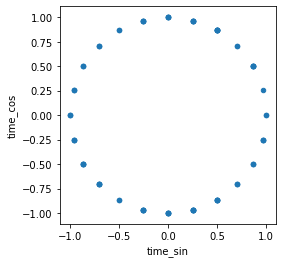

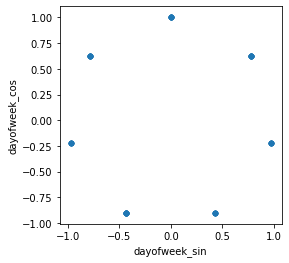

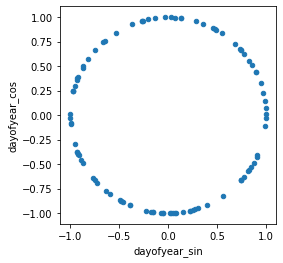

In [8]:
data_frame.sample(100).plot.scatter("time_sin", "time_cos").set_aspect("equal")
data_frame.sample(100).plot.scatter("dayofweek_sin", "dayofweek_cos").set_aspect("equal")
data_frame.sample(100).plot.scatter("dayofyear_sin", "dayofyear_cos").set_aspect("equal")

In [9]:
wind_direction = data_frame['wind_direction']
#data_frame.drop("wind_direction")
data_frame["wind_direction_sin"] = np.sin(2 * np.pi * wind_direction / 360)
data_frame["wind_direction_cos"] = np.cos(2 * np.pi * wind_direction / 360)
data_frame.loc[data_frame["wind_direction"].isna(), ["wind_direction_sin", "wind_direction_cos"]] = 0
data_frame.loc[data_frame["wind_speed"] == 0, ["wind_direction_sin", "wind_direction_cos"]] = 0

In [10]:
data_frame.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,wind_direction,wind_speed,time_sin,time_cos,dayofweek_sin,dayofweek_cos,dayofyear_sin,dayofyear_cos,wind_direction_sin,wind_direction_cos
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,...,0.0,0.0,0.0,1.0,-0.433884,-0.900969,0.017166,0.999853,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,...,0.0,0.0,0.0,1.0,-0.433884,-0.900969,0.017166,0.999853,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,...,0.0,0.0,0.0,1.0,-0.433884,-0.900969,0.017166,0.999853,0.0,0.0
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,...,0.0,0.0,0.0,1.0,-0.433884,-0.900969,0.017166,0.999853,0.0,0.0
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,...,0.0,0.0,0.0,1.0,-0.433884,-0.900969,0.017166,0.999853,0.0,0.0


In [11]:
data_frame["wind_direction"].unique()

array([  0., 240., 270., 350., 280., 200., 250.,  70., 230., 360., 260.,
        20., 190., 300., 330.,  10.,  nan,  50., 170.,  90., 160.,  30.,
       340., 110., 310., 130., 290., 100., 120.,  60., 150., 210.,  80.,
        40., 320., 140., 220., 180., 174., 176.,  84., 198., 196., 202.])

In [12]:
data_frame[data_frame["wind_direction"].isna()].head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,wind_direction,wind_speed,time_sin,time_cos,dayofweek_sin,dayofweek_cos,dayofyear_sin,dayofyear_cos,wind_direction_sin,wind_direction_cos
4284,656,0,2016-01-01 02:00:00,28.799999,5,Other,5769,1976.0,1.0,3.0,...,NaN,1.5,0.5,0.866025,-0.433884,-0.900969,0.017166,0.999853,0.0,0.0
4285,657,0,2016-01-01 02:00:00,21.200001,5,Education,109071,1966.0,3.0,3.0,...,NaN,1.5,0.5,0.866025,-0.433884,-0.900969,0.017166,0.999853,0.0,0.0
4286,658,0,2016-01-01 02:00:00,5.200000,5,Entertainment/public assembly,31075,1976.0,2.0,3.0,...,NaN,1.5,0.5,0.866025,-0.433884,-0.900969,0.017166,0.999853,0.0,0.0
4287,659,0,2016-01-01 02:00:00,9.000000,5,Entertainment/public assembly,15306,1976.0,2.0,3.0,...,NaN,1.5,0.5,0.866025,-0.433884,-0.900969,0.017166,0.999853,0.0,0.0
4288,660,0,2016-01-01 02:00:00,3.305000,5,Entertainment/public assembly,5447,1976.0,1.0,3.0,...,NaN,1.5,0.5,0.866025,-0.433884,-0.900969,0.017166,0.999853,0.0,0.0


In [13]:
data_frame[data_frame["wind_speed"]==0].head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,wind_direction,wind_speed,time_sin,time_cos,dayofweek_sin,dayofweek_cos,dayofyear_sin,dayofyear_cos,wind_direction_sin,wind_direction_cos
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,...,0.0,0.0,0.0,1.0,-0.433884,-0.900969,0.017166,0.999853,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,...,0.0,0.0,0.0,1.0,-0.433884,-0.900969,0.017166,0.999853,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,...,0.0,0.0,0.0,1.0,-0.433884,-0.900969,0.017166,0.999853,0.0,0.0
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,...,0.0,0.0,0.0,1.0,-0.433884,-0.900969,0.017166,0.999853,0.0,0.0
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,...,0.0,0.0,0.0,1.0,-0.433884,-0.900969,0.017166,0.999853,0.0,0.0


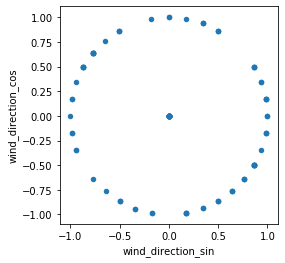

In [14]:
data_frame.sample(100).plot.scatter("wind_direction_sin", "wind_direction_cos").set_aspect("equal")